In [13]:
# train.py


import os
# choose one of the two configs
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"


import torch
import torch.optim as optim
import numpy as np
import scanpy as sc

from dataloader import make_dataloader
from model import VAEModel
import scvelo as scv


In [14]:
def train_regime1(model, loader, optimizer, device, epochs):
    # Regime1: train encoder and gene_decoder only; freeze velocity_decoder
    # Freeze velocity_decoder parameters
    for param in model.velocity_decoder.parameters():
        param.requires_grad = False
    # Unfreeze encoder and gene_decoder
    for group in (model.encoder, model.gene_decoder):
        for param in group.parameters():
            param.requires_grad = True

    model.first_regime = True
    model.train()
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        for x, idx, x_neigh in loader:
            x = x.to(device)
            x_neigh = x_neigh.to(device)
            recon, v_pred, v_gp, mean, logvar = model(x)
            loss_recon = model.reconstruction_loss(recon, x)
            loss_kl = model.kl_divergence(mean, logvar)
            loss = loss_recon + 1e-2 * loss_kl
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
        epoch_loss = running_loss / len(loader.dataset)
        print(f"[Regime1] Epoch {epoch}/{epochs} - Loss: {epoch_loss:.4f}")

def compute_latent(model, loader, device):
    """
    Compute latent embeddings for all cells via DataLoader.
    Ensures correct mapping even if loader is shuffled.
    """
    model.eval()
    # number of cells
    n_cells = loader.dataset.adata.n_obs
    latent_list = []
    idx_all = []

    with torch.no_grad():
        for x, idx, x_neigh in loader:
            x = x.to(device)
            z, _, _ = model.encoder(x)
            latent_list.append(z.cpu())
            idx_all.extend(idx.numpy().tolist())

    # concatenate and reorder
    z_concat = torch.cat(latent_list, dim=0)
    latent_dim = z_concat.size(1)
    z_all = torch.zeros((n_cells, latent_dim), dtype=z_concat.dtype)
    z_all[idx_all] = z_concat
    return z_all.numpy()

def train_regime2(model, loader, optimizer, device, epochs):
    # Regime2: train only velocity_decoder; freeze encoder and gene_decoder
    # Freeze encoder and gene_decoder parameters
    for group in (model.encoder, model.gene_decoder):
        for param in group.parameters():
            param.requires_grad = False
    # Unfreeze velocity_decoder
    for param in model.velocity_decoder.parameters():
        param.requires_grad = True

    model.first_regime = False
    model.train()
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        for x, idx, x_neigh, z, z_neigh in loader:
            x, x_neigh, z, z_neigh = [t.to(device) for t in (x, x_neigh, z, z_neigh)]
            _, v_pred, v_gp, _, _ = model(x)
            xz = torch.cat([x, z], dim=1)
            xz_neigh = torch.cat([x_neigh, z_neigh], dim=2)
            v_comb = torch.cat([v_pred, v_gp], dim=1)
            loss_vel = model.velocity_loss(v_comb, xz, xz_neigh)
            optimizer.zero_grad()
            loss_vel.backward()
            optimizer.step()
            running_loss += loss_vel.item() * x.size(0)
        epoch_loss = running_loss / len(loader.dataset)
        print(f"[Regime2] Epoch {epoch}/{epochs} - Velocity Loss: {epoch_loss:.4f}")

def annotate_adata(model, loader, adata, device,
                  unspliced_key: str = 'unspliced',
                  spliced_key: str = 'spliced'):
    """
    After training, use a DataLoader (first_regime=False) to annotate AnnData:
      - reconstructed unspliced & spliced expression
      - unspliced & spliced velocity
      - gene-program velocity (velocity_gp)
    """
    model.eval()
    n_cells = adata.n_obs
    # dimensions
    u = adata.layers[unspliced_key]
    G = u.shape[1] if not hasattr(u, 'shape') else u.shape[1]
    # placeholder arrays
    recon_all = np.zeros((n_cells, G*2), dtype=np.float32)
    vel_all   = np.zeros((n_cells, G*2), dtype=np.float32)
    # we will infer gp_dim from first batch
    gp_dim = None

    with torch.no_grad():
        for x, idx, x_neigh, z, z_neigh in loader:
            x = x.to(device)
            recon_batch, vel_batch, gp_batch, _, _ = model(x)
            recon_np = recon_batch.cpu().numpy()
            vel_np   = vel_batch.cpu().numpy()
            gp_np    = gp_batch.cpu().numpy()
            batch_idx = idx.numpy()
            recon_all[batch_idx] = recon_np
            vel_all[batch_idx]   = vel_np
            if gp_dim is None:
                gp_dim = gp_np.shape[1]
                gp_all = np.zeros((n_cells, gp_dim), dtype=np.float32)
            gp_all[batch_idx] = gp_np

    # split expression / spliced parts
    recon_u = recon_all[:, :G]
    recon_s = recon_all[:, G:]
    vel_u   = vel_all[:, :G]
    vel_s   = vel_all[:, G:]

    # store in AnnData
    adata.layers['recon_u']    = recon_u
    adata.layers['recon']      = recon_s
    adata.layers['velocity_u'] = vel_u
    adata.layers['velocity']   = vel_s
    adata.obsm['velocity_gp']          = gp_all


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load preprocessed AnnData
adata = sc.read_h5ad("/home/lgolinelli/git/lineageVI/input_processed_anndata/pancreas.h5ad")

# hyperparameters
K = 10
batch_size = 64
lr = 1e-3
epochs1 = 100
epochs2 = 100
n_hidden = 128
mask_key = 'I'
gene_prior = True
seeds = [1,1,2]

# initialize model and optimizer
model = VAEModel(
    adata,
    n_hidden=n_hidden,
    mask_key=mask_key,
    gene_prior=gene_prior,
    seed=seeds[0],
).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Regime 1
loader1 = make_dataloader(adata, first_regime=True, K=K, batch_size=batch_size, shuffle=True, seed=seeds[1])
train_regime1(model, loader1, optimizer, device, epochs1)

# compute and store latent embeddings
z_emb = compute_latent(model, loader1, device)
adata.obsm['z'] = z_emb

# Regime 2
loader2 = make_dataloader(adata, first_regime=False, K=K, batch_size=batch_size, shuffle=False, seed=seeds[2])
train_regime2(model, loader2, optimizer, device, epochs2)

# annotate via DataLoader2
annotate_adata(model, loader2, adata, device)
#adata.write("adata_with_velocity.h5ad")

# save model weights
#torch.save(model.state_dict(), "vae_velocity_model.pt")

[Regime1] Epoch 1/100 - Loss: 20.7178
[Regime1] Epoch 2/100 - Loss: 20.5537
[Regime1] Epoch 3/100 - Loss: 20.3248
[Regime1] Epoch 4/100 - Loss: 19.9239
[Regime1] Epoch 5/100 - Loss: 19.3767
[Regime1] Epoch 6/100 - Loss: 18.7597
[Regime1] Epoch 7/100 - Loss: 18.1204
[Regime1] Epoch 8/100 - Loss: 17.4980
[Regime1] Epoch 9/100 - Loss: 16.8893
[Regime1] Epoch 10/100 - Loss: 16.3244
[Regime1] Epoch 11/100 - Loss: 15.7920
[Regime1] Epoch 12/100 - Loss: 15.2842
[Regime1] Epoch 13/100 - Loss: 14.8147
[Regime1] Epoch 14/100 - Loss: 14.3733
[Regime1] Epoch 15/100 - Loss: 13.9475
[Regime1] Epoch 16/100 - Loss: 13.5650
[Regime1] Epoch 17/100 - Loss: 13.1806
[Regime1] Epoch 18/100 - Loss: 12.8322
[Regime1] Epoch 19/100 - Loss: 12.4989
[Regime1] Epoch 20/100 - Loss: 12.1904
[Regime1] Epoch 21/100 - Loss: 11.8815
[Regime1] Epoch 22/100 - Loss: 11.5871
[Regime1] Epoch 23/100 - Loss: 11.3341
[Regime1] Epoch 24/100 - Loss: 11.0710
[Regime1] Epoch 25/100 - Loss: 10.8165
[Regime1] Epoch 26/100 - Loss: 10.

In [15]:
adata.layers['velocity'] *=-1

computing velocity graph (using 1/64 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


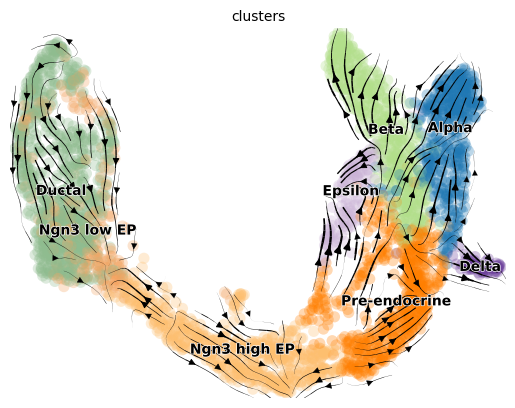

In [16]:
sc.pp.neighbors(adata)
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color='clusters')

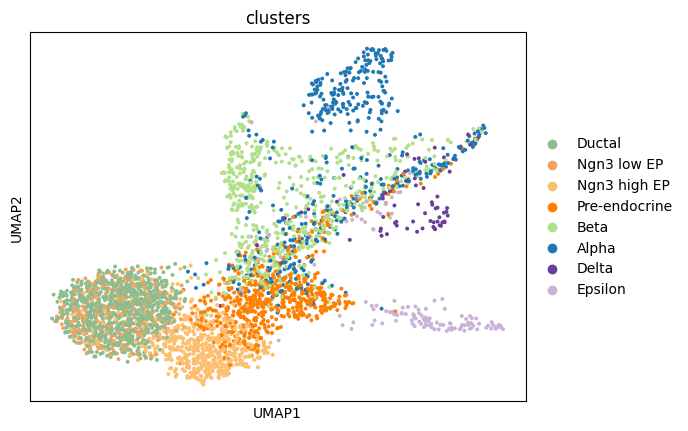

In [17]:
sc.pp.neighbors(adata, use_rep='z')
sc.tl.umap(adata)
sc.pl.umap(adata, color='clusters')

In [18]:
adata_gp = sc.AnnData